# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from pprint import pprint
import os
import glob
from tqdm import tqdm
import json
import threading
from matplotlib.backends.backend_pdf import PdfPages

from scipy.optimize import curve_fit



# File Parser

In [66]:
def parse_file(file_path):
    data = {}
    current_key = None
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith("Values in master"):
                current_key = "Values in master"
                data[current_key] = []
            elif line.startswith("True values"):
                current_key = "True values"
                data[current_key] = []
            elif line.startswith("Differences"):
                current_key = "Differences"
                data[current_key] = []
            elif current_key is not None:
                if line.startswith("[") and line.endswith("]"):
                    data[current_key] = eval(line)
                else:
                    data[current_key].append(line)
    return data

# Reading data from all folders

In [72]:
def process_folder(folder):
    folder_path = os.path.join(logs_folder, folder)
    if os.path.isdir(folder_path) and folder != "backup":
        data[folder] = {}
        log_files = glob.glob(os.path.join(folder_path, "log_*.txt"))
        for log_file in log_files:
            log_filename = os.path.basename(log_file)
            data[folder][log_filename] = parse_file(log_file)
    return data

# Get the current directory (assuming you are in the "analysis" folder)
current_directory = os.getcwd()
# Go one level up
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))

# Go one level down to access the "logs" folder
logs_folder = os.path.join(parent_directory, "log")
data = {}  # Initialize the top-level dictionary
# List of folders to process
folders_to_process = os.listdir(logs_folder)
# Create and start threads for processing folders
threads = []
for folder in folders_to_process:
    thread = threading.Thread(target=process_folder, args=(folder,))
    thread.start()
    threads.append(thread)

# Wait for all threads to complete
for thread in threads:
    thread.join()

# Writing all data to a text file

In [73]:
# Writing the data dictionary to a file
with open('allData.txt', 'w') as file:
    json.dump(data, file)

# Reading data back from text file

In [26]:
# Reading the data dictionary from the file
with open('allData.txt', 'r') as file:
    data = json.load(file)



In [81]:
print(data['1'])
print(data.keys())
print(data['1'].keys())
print(np.mean(data['1']['log_10.txt']['Differences']))

{'log_10.txt': {'Values in master': ['4', '8', '9', '3', '6', '2', '5', '7', '1', '0'], 'True values': [('9', 10), ('8', 9), ('7', 8), ('6', 7), ('5', 6), ('4', 5), ('3', 4), ('2', 3), ('1', 2), ('0', 1)], 'Differences': [5, 0, 2, 3, 1, 2, 2, 5, 0, 0]}, 'log_100.txt': {'Values in master': ['98', '99', '96', '97', '92', '95', '94', '87', '91', '85', '81', '79', '89', '90', '74', '77', '93', '88', '71', '64', '86', '84', '70', '75', '80', '76', '72', '83', '56', '82', '73', '54', '67', '48', '78', '57', '65', '68', '44', '61', '69', '58', '52', '63', '60', '66', '62', '59', '51', '46', '49', '35', '53', '55', '43', '45', '42', '41', '33', '38', '39', '40', '36', '47', '50', '32', '30', '34', '37', '29', '28', '22', '31', '25', '27', '23', '26', '17', '18', '20', '14', '21', '24', '10', '19', '11', '9', '15', '16', '12', '13', '6', '7', '8', '4', '5', '1', '3', '2', '0'], 'True values': [('99', 100), ('98', 99), ('97', 98), ('96', 97), ('95', 96), ('94', 95), ('93', 94), ('92', 93), ('91'

# Increment of put requests vs mean difference

In [19]:
def getData(data,numOfKeys):
    ret = {}
    numOfKeys = "log_" + str(numOfKeys) + ".txt"
    for incrementPutRequest in data.keys():   
        mean = np.mean(data[incrementPutRequest][numOfKeys]['Differences'])
        ret[incrementPutRequest] = mean
    return ret
def general_fit_function(x, *params):
    return np.polyval(params, x)


# Plots

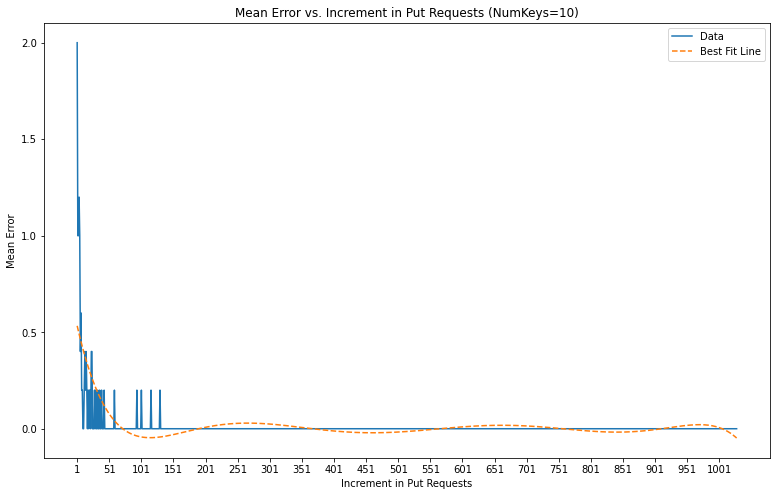

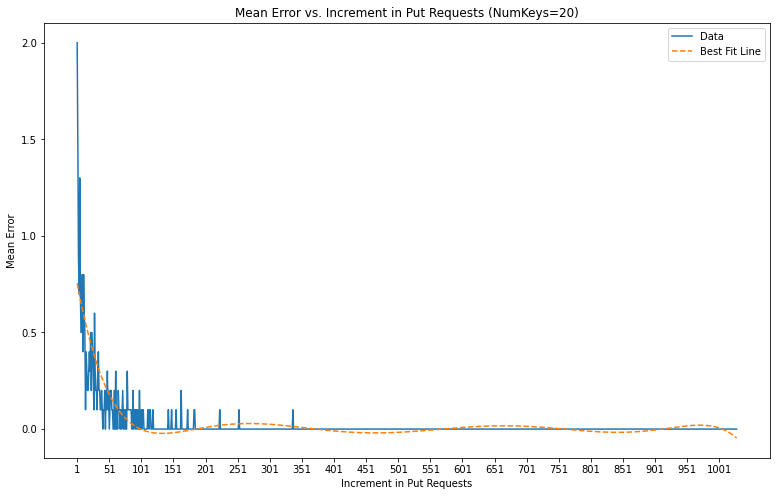

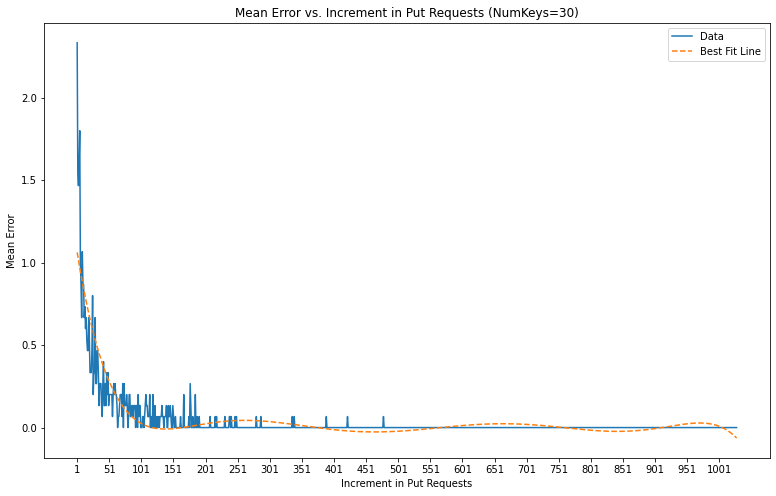

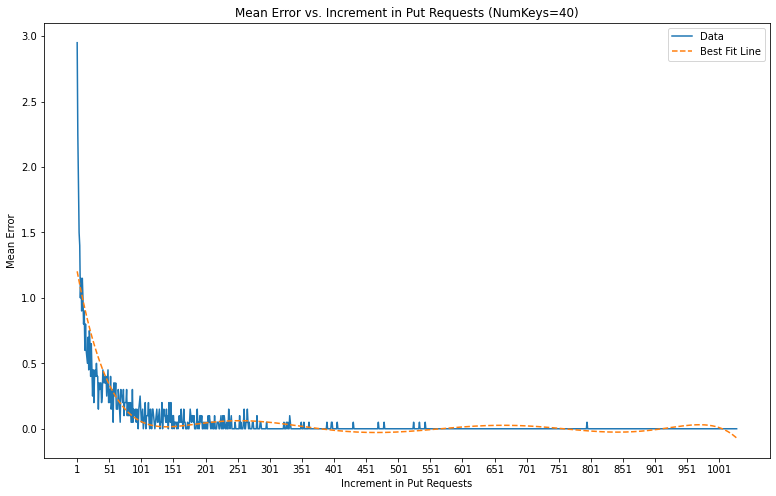

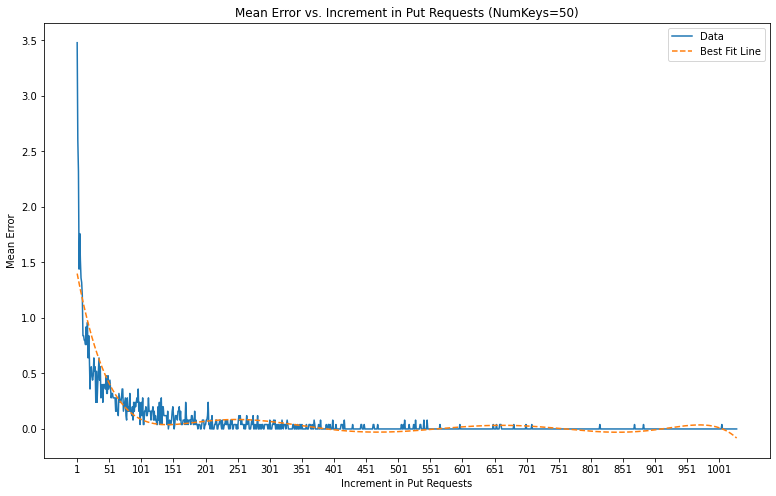

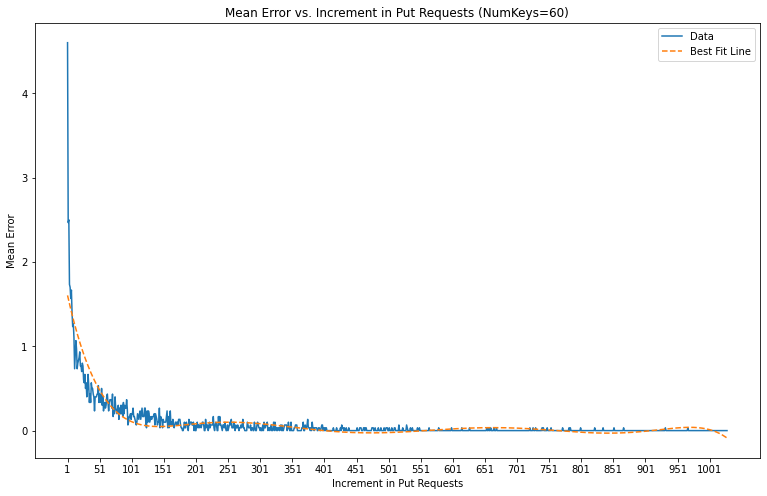

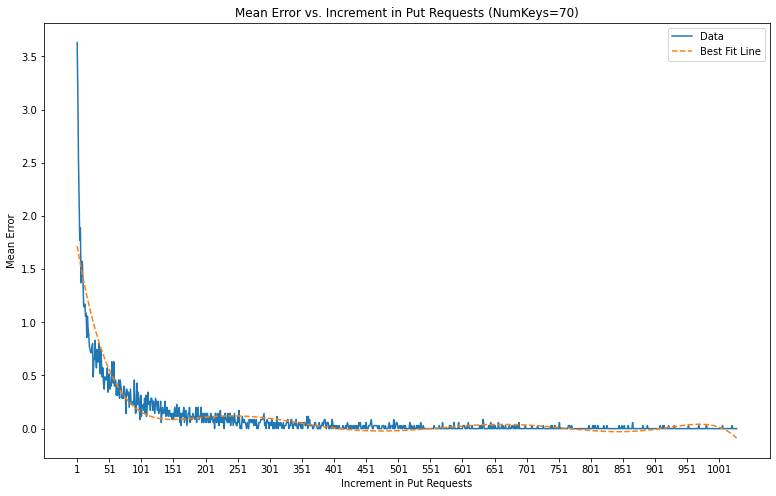

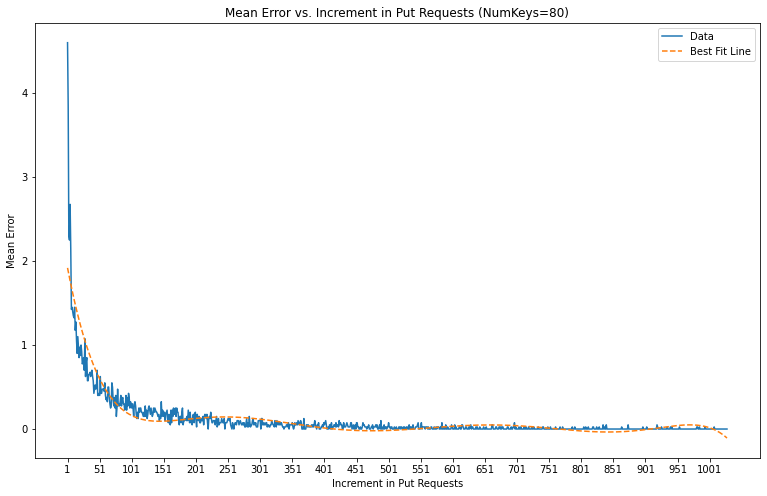

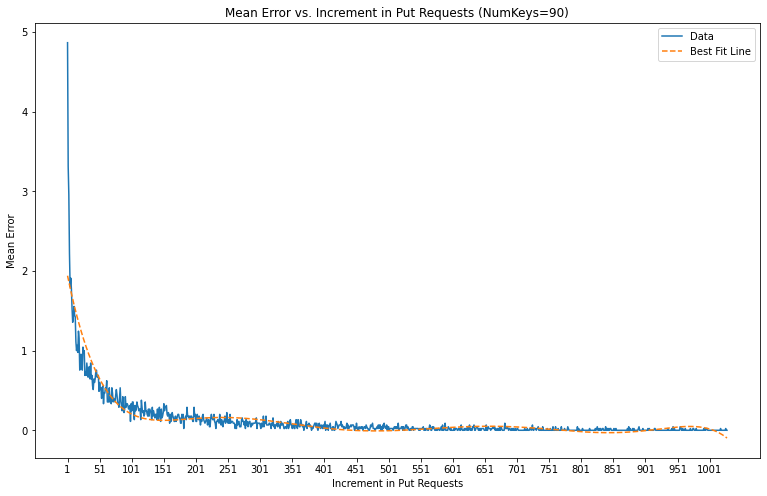

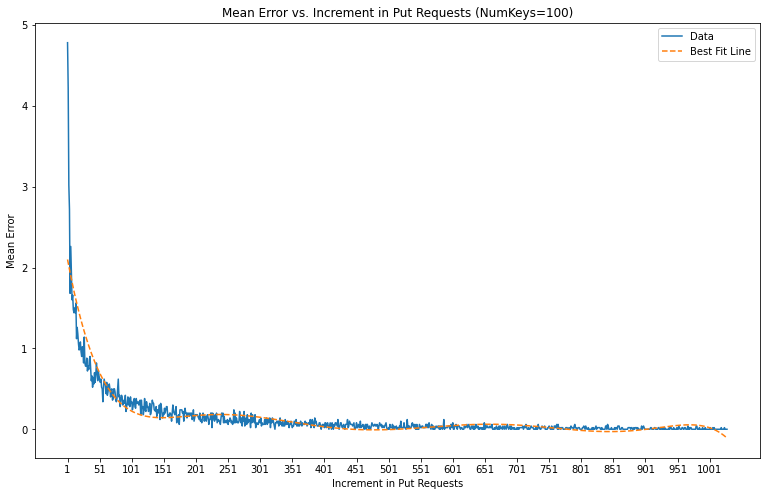

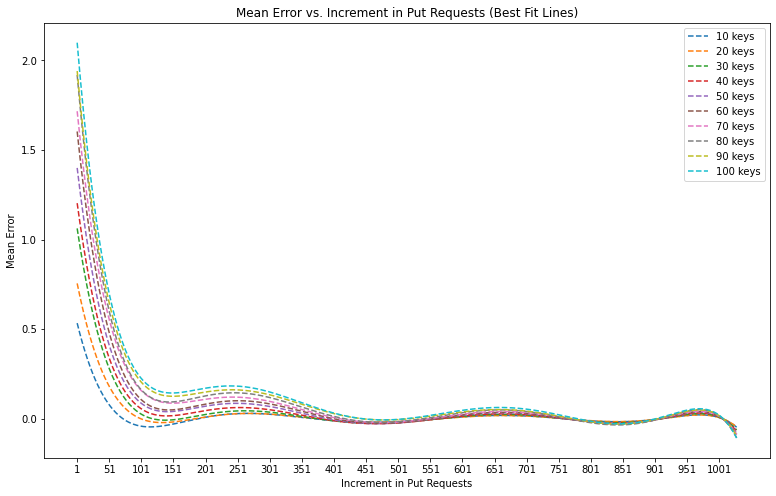

In [32]:
diffNumOfKeys = ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']

# Initialize lists to store the data
X_values = []
Y_values = []
best_fit_lines = []

# Create a list to store individual plots
individual_plots = []

# Initialize the PDF file
pdf_filename = "output_plots.pdf"
pdf = PdfPages(pdf_filename)

# Assuming getData() generates data for a given number of keys
for numKeys in diffNumOfKeys:
    dataTemp = getData(data, numKeys)  # Replace with your actual function
    X = [float(value) for value in dataTemp.keys()]
    Y = list(dataTemp.values())

    # Combine and sort X and Y based on X
    X, Y = zip(*sorted(zip(X, Y)))

    # Append the data to the lists
    X_values.append(X)
    Y_values.append(Y)

    # Calculate the best fit line (non-linear regression)
    popt, _ = curve_fit(general_fit_function, X, Y, p0=(1, 1, 1, 1,1,1,1,1))  # You can adjust p0 as needed
    best_fit_lines.append(np.poly1d(popt))
    
    

    # Create individual plots
    plt.figure(figsize=(13, 8))
    plt.plot(X, Y, label="Data")
    plt.plot(X, best_fit_lines[-1](X), '--', label="Best Fit Line")
    plt.xlabel("Increment in Put Requests")
    plt.ylabel("Mean Error")
    plt.title(f"Mean Error vs. Increment in Put Requests (NumKeys={numKeys})")
    plt.xticks(range(1, 1051, 50))
    plt.legend()  # Add a legend for this individual plot

    # Append the individual plots to the list
    individual_plots.append(plt.gcf())

# Create a new figure for the combined plot
plt.figure(figsize=(13, 8))

# Plot the best fit lines for each set of values in the combined plot
for i, numKeys in enumerate(diffNumOfKeys):
    plt.plot(X_values[i], best_fit_lines[i](X_values[i]), '--', label=f"{numKeys} keys")

plt.xlabel("Increment in Put Requests")
plt.ylabel("Mean Error")
plt.title("Mean Error vs. Increment in Put Requests (Best Fit Lines)")
plt.legend()
plt.xticks(list(range(1, 1051, 50)))

# Save the individual plots to the PDF file
for plot in individual_plots:
    pdf.savefig(figure=plot)

# Save the combined plot with best fit lines only to the PDF file
pdf.savefig()

# Close the PDF file
pdf.close()

# Display the combined plot
plt.show()
